In [1]:
cd ..

/home/abhishekabhishek/git/UnsupGenModbyMPS


In [2]:
%load_ext autoreload

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import tensornetwork as tn

from MPScumulant import MPS_c
import mps_circuit_helpers as helpers
import mps_circuits
import metrics
import mps_helpers

In [4]:
# load and format the data
data = np.load('BStest/BSdata.npy')
data_states = data.reshape(-1, 16).astype(np.int8)

In [5]:
# load the trained MPS (with max_bond_dim = 4)
mps = MPS_c(16, max_bond_dim=4)
mps.loadMPS('BS-4-MPS')

# check the properties of the matrices in the MPS
for i in range(len(mps.matrices)):
    tn_core = mps.matrices[i]
    print(i, tn_core.shape)

0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 4)
3 (4, 2, 4)
4 (4, 2, 4)
5 (4, 2, 4)
6 (4, 2, 4)
7 (4, 2, 4)
8 (4, 2, 4)
9 (4, 2, 4)
10 (4, 2, 4)
11 (4, 2, 4)
12 (4, 2, 4)
13 (4, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


Let's first setup the generic MPS circuit (to be able to compute the fidelity during the analytic decomposition process)

In [6]:
%autoreload
mps_unitaries = helpers.get_mps_unitaries(mps)
mps_circuit = mps_circuits.mps_unitaries_to_circuit(mps_unitaries,
                                                   return_state=True)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 4), 4
i = 3, (4, 2, 4), 4
i = 4, (4, 2, 4), 4
i = 5, (4, 2, 4), 4
i = 6, (4, 2, 4), 4
i = 7, (4, 2, 4), 4
i = 8, (4, 2, 4), 4
i = 9, (4, 2, 4), 4
i = 10, (4, 2, 4), 4
i = 11, (4, 2, 4), 4
i = 12, (4, 2, 4), 4
i = 13, (4, 2, 4), 4
i = 14, (4, 2, 2), 4
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


(<Figure size 1368x1224 with 1 Axes>, <Axes: >)

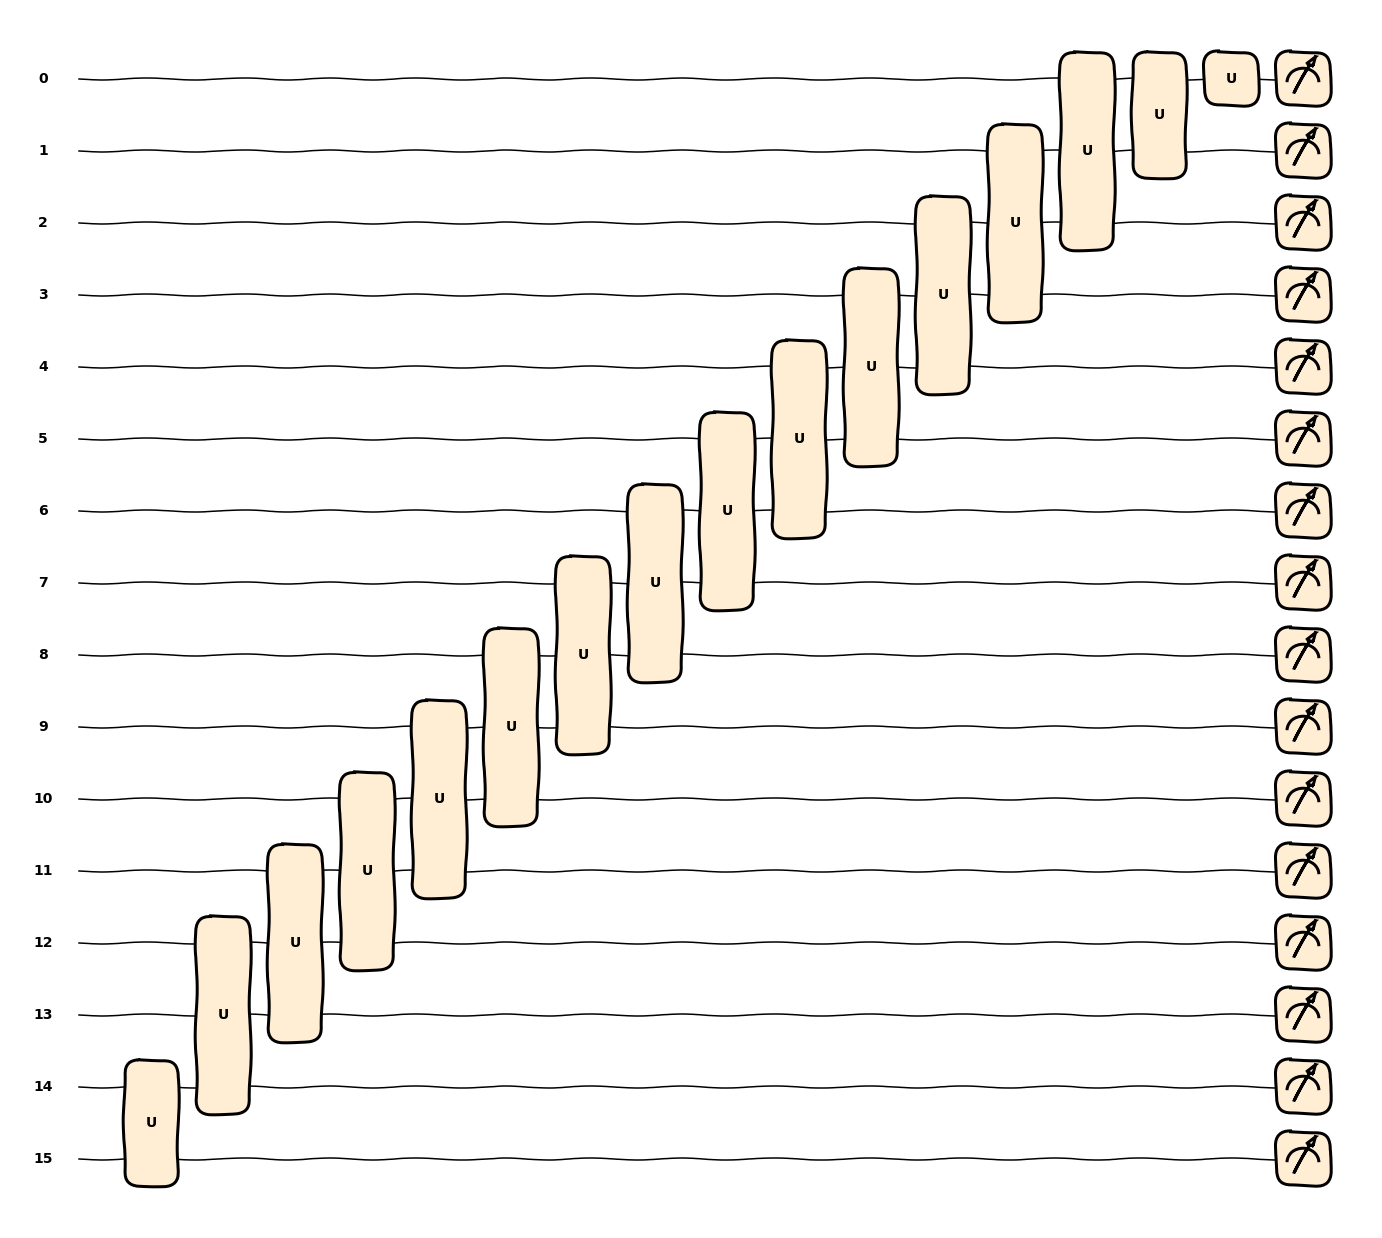

In [7]:
qml.drawer.draw_mpl(mps_circuit, style="sketch")()

In [31]:
%autoreload

# create a tensornetwork MPS
tn_mps = tn.FiniteMPS(mps.matrices, canonicalize=False)

# set some loop parameters for the decomposition
max_layers = 10
circ_fidelities = []
layer_list = []

layer = 0
curr_fidelity = 0.

while layer < max_layers and curr_fidelity < 0.99:
    # truncate the MPS to chi = 2 via SVD
    tn_mps_trun = mps_helpers.truncate_mps(tn_mps, max_singular_values=2)
    
    # convert the truncated MPS to a list of 2-qubit unitaries
    mps_unitaries = helpers.get_mps_unitaries(mps_helpers.tn_to_mps(
        tn_mps_trun
    ))
    layer_list.append(mps_unitaries)
    
    # apply the disentangler i.e. conjugated MPS unitaries to the MPS
    # set the maximum singular value according to the original MPS being mapped
    mps_helpers.apply_conjugate_unitaries(mps_unitaries, tn_mps,
                                          max_singular_value=4)
    
    # compute the current fidelity using the layered circuit
    # TODO let's check everything else works first - done
    decomp_mps_circuit = mps_circuits.mps_layers_to_circuit(layer_list,
                                                            return_state=True)
    curr_fidelity = qml.math.fidelity(mps_circuit(), decomp_mps_circuit())
    circ_fidelities.append(curr_fidelity)
    layer+=1
    

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 2), 2
i = 2, (2, 2, 2), 2
i = 3, (2, 2, 2), 2
i = 4, (2, 2, 2), 2
i = 5, (2, 2, 2), 2
i = 6, (2, 2, 2), 2
i = 7, (2, 2, 2), 2
i = 8, (2, 2, 2), 2
i = 9, (2, 2, 2), 2
i = 10, (2, 2, 2), 2
i = 11, (2, 2, 2), 2
i = 12, (2, 2, 2), 2
i = 13, (2, 2, 2), 2
i = 14, (2, 2, 2), 2
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14
padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 2), 2
i = 2, (2, 2, 2), 2
i = 3, (2, 2, 2), 2
i = 4, (2, 2, 2), 2
i = 5, (2, 2, 2), 2
i = 6, (2, 2, 2), 2
i = 7, (2, 2, 2), 2
i = 8, (2, 2, 2), 2
i = 9, (2, 2, 2), 2
i = 10, (2, 2, 2), 2
i = 11, (2, 2, 2), 2
i = 12, (2, 2, 2), 2
i = 13, (2, 2, 2), 2
i = 14, (2, 2, 2), 2
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
b

Ok. So we've checked that the two-qubit layered circuits can be constructed reasonably - let's try to compute the fidelities

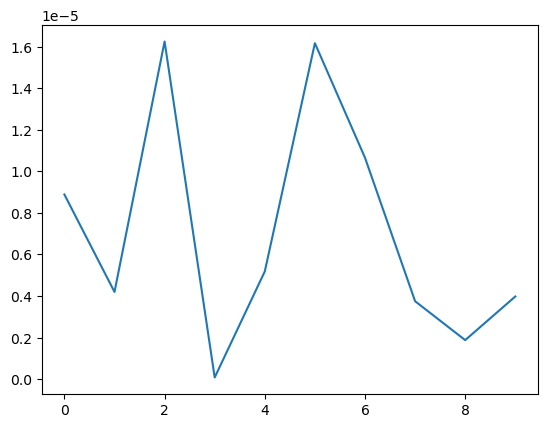

In [32]:
plt.plot(circ_fidelities)

In [12]:
circ_fidelities

[0.016191302388605396,
 0.019230468375834347,
 0.01232839936706598,
 0.009791427503674462,
 0.010532330509425711,
 0.011746344757717148,
 0.011869716665265482,
 0.01114644648447785,
 0.008149996247818448,
 0.008252134114062044]

(<Figure size 3700x1700 with 1 Axes>, <Axes: >)

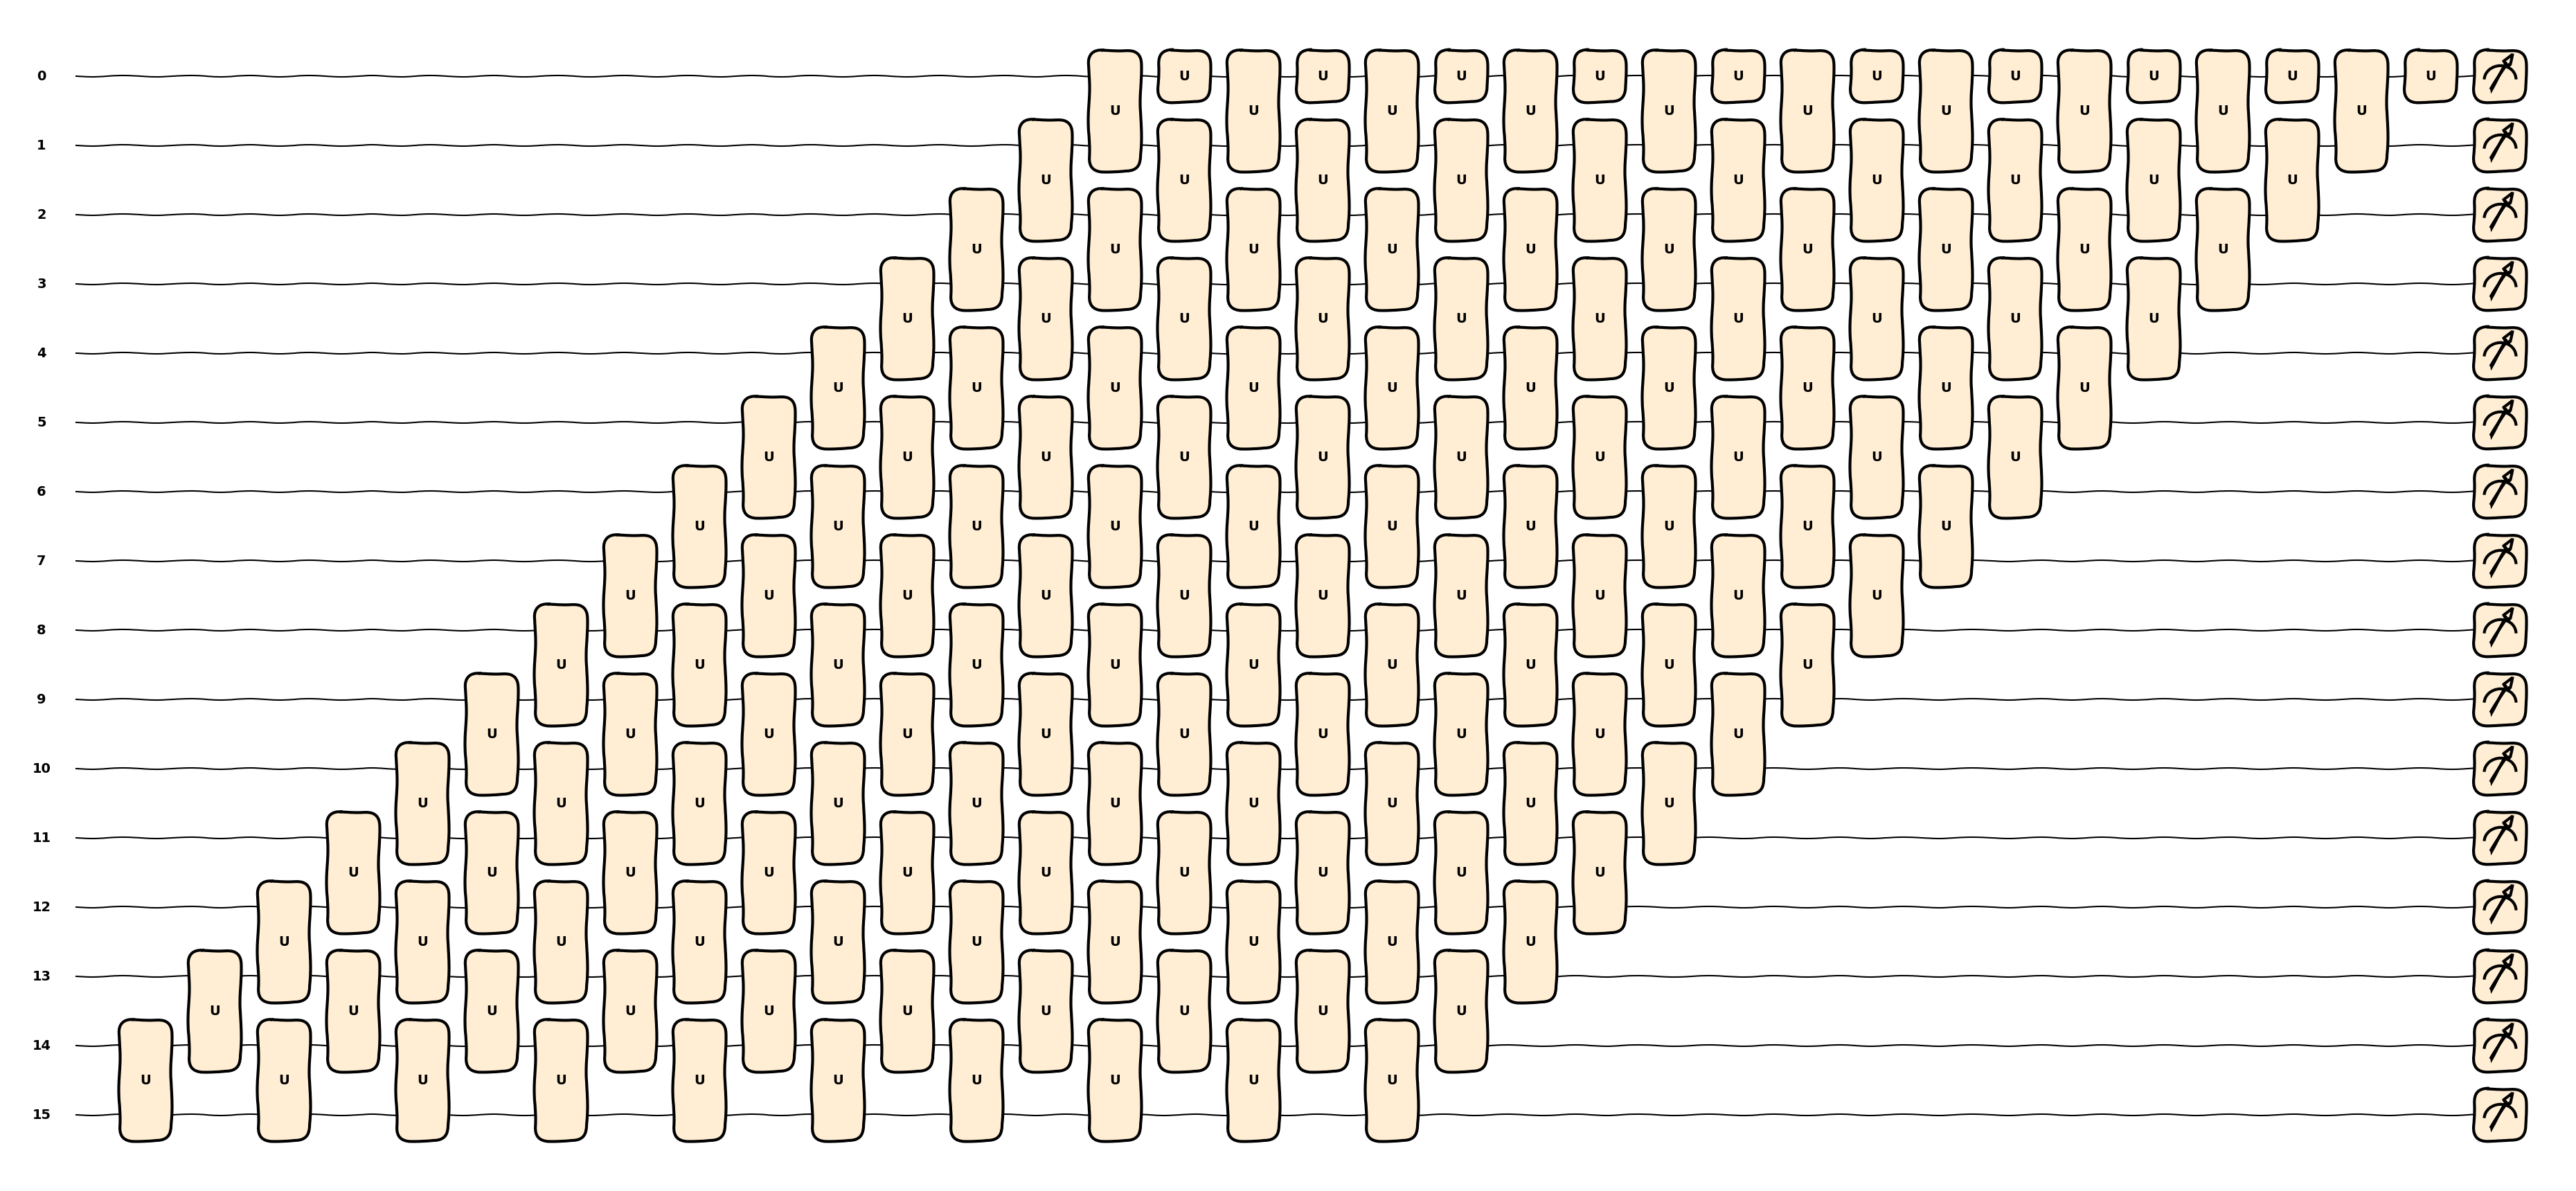

In [13]:
qml.drawer.draw_mpl(decomp_mps_circuit, style="sketch")()

In [19]:
cnot = qml.CNOT(wires=[0, 1]).compute_matrix()

In [17]:
qml.CNOT(wires=[0, 1]).compute_matrix().reshape(2, 2, 2, 2)

array([[[[1, 0],
         [0, 0]],

        [[0, 1],
         [0, 0]]],


       [[[0, 0],
         [0, 1]],

        [[0, 0],
         [1, 0]]]])

In [18]:
G = np.zeros((2, 2, 2, 2))

In [23]:
for i in range(4):
    print(cnot[i].reshape(2, 2))

[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 0]
 [0 1]]
[[0 0]
 [1 0]]


In [27]:
G[:, :, 0, 0] = cnot[0].reshape(2, 2)
G[:, :, 0, 1] = cnot[1].reshape(2, 2)
G[:, :, 1, 0] = cnot[2].reshape(2, 2)
G[:, :, 1, 1] = cnot[3].reshape(2, 2)

In [28]:
G

array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 1.]],

        [[0., 0.],
         [1., 0.]]]])

In [26]:
G

array([[[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]])

Let's check if the new mapping did anything meaningful!

In [52]:
%autoreload

# create a tensornetwork MPS
tn_mps = tn.FiniteMPS(mps.matrices, canonicalize=False)

# set some loop parameters for the decomposition
max_layers = 30
circ_fidelities = []
layer_list = []

layer = 0
curr_fidelity = 0.

while layer < max_layers and curr_fidelity < 0.99:
    # truncate the MPS to chi = 2 via SVD
    tn_mps_trun = mps_helpers.truncate_mps(tn_mps, max_singular_values=2)
    
    # convert the truncated MPS to a list of 2-qubit unitaries
    mps_unitaries = helpers.get_mps_unitaries(mps_helpers.tn_to_mps(
        tn_mps_trun
    ))
    layer_list.append(mps_unitaries)
    
    # apply the disentangler i.e. conjugated MPS unitaries to the MPS
    # set the maximum singular value according to the original MPS being mapped
    mps_helpers.apply_conjugate_unitaries(mps_unitaries, tn_mps,
                                          max_singular_value=4)
    
    # compute the current fidelity using the layered circuit
    # TODO let's check everything else works first - done
    decomp_mps_circuit = mps_circuits.mps_layers_to_circuit(layer_list,
                                                            return_state=True)
    curr_fidelity = qml.math.fidelity(mps_circuit(), decomp_mps_circuit())
    circ_fidelities.append(curr_fidelity)
    layer+=1

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 2), 2
i = 2, (2, 2, 2), 2
i = 3, (2, 2, 2), 2
i = 4, (2, 2, 2), 2
i = 5, (2, 2, 2), 2
i = 6, (2, 2, 2), 2
i = 7, (2, 2, 2), 2
i = 8, (2, 2, 2), 2
i = 9, (2, 2, 2), 2
i = 10, (2, 2, 2), 2
i = 11, (2, 2, 2), 2
i = 12, (2, 2, 2), 2
i = 13, (2, 2, 2), 2
i = 14, (2, 2, 2), 2
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14
padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 2), 2
i = 2, (2, 2, 2), 2
i = 3, (2, 2, 2), 2
i = 4, (2, 2, 2), 2
i = 5, (2, 2, 2), 2
i = 6, (2, 2, 2), 2
i = 7, (2, 2, 2), 2
i = 8, (2, 2, 2), 2
i = 9, (2, 2, 2), 2
i = 10, (2, 2, 2), 2
i = 11, (2, 2, 2), 2
i = 12, (2, 2, 2), 2
i = 13, (2, 2, 2), 2
i = 14, (2, 2, 2), 2
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
b

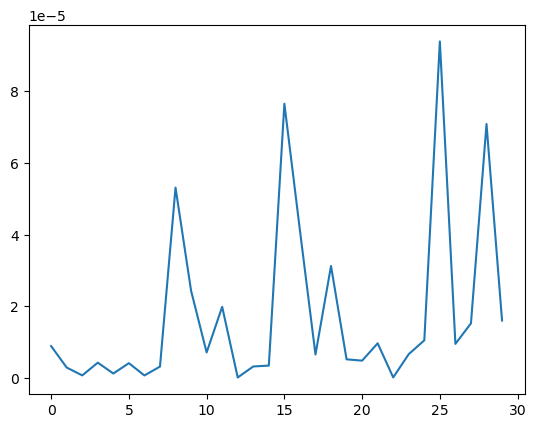

In [53]:
plt.plot(circ_fidelities)

The above is pretty much the same as the one using reshape - should we try switching the idxs maybe! None works - not sure where the problem is!

It's time to close this thread and write the report.